In [1]:
import numpy as np
from astropy.io import fits


class Sightline(object):

    def __init__(self, id, dlas=None, flux=None, loglam=None, z_qso=None):
        """
        Args:
            id (int):  Index identifier for the sightline
            dlas (list): List of DLAs
            flux (np.ndarray):
            loglam (np.ndarray):
                log10 of observed wavelength values
            z_qso (float):
                Quasar redshift
        """
        self.flux = flux
        self.loglam = loglam
        self.id = id
        self.dlas = dlas
        self.z_qso = z_qso
        self.data_markers = []     # An array of DataMarker objects which mark areas of the sightline

        # Attributes
        self.prediction = None
        self.classification = None
        self.offsets = None
        self.column_density = None


    # Returns the data in the legacy data1, qso_z format for code that hasn't been updated to the new format yet
    def get_legacy_data1_format(self):
        raw_data = {}
        raw_data['flux'] = self.flux
        raw_data['loglam'] = self.loglam
        raw_data['plate'] = self.id.plate if hasattr(self.id, 'plate') else 0
        raw_data['mjd'] = self.id.mjd if hasattr(self.id, 'mjd') else 0
        raw_data['fiber'] = self.id.fiber if hasattr(self.id, 'fiber') else 0
        raw_data['ra'] = self.id.ra if hasattr(self.id, 'ra') else 0
        raw_data['dec'] = self.id.dec if hasattr(self.id, 'dec') else 0
        return raw_data, self.z_qso


    # Clears all fields of the DLA
    def clear(self):
        self.flux = None
        self.loglam = None
        self.id = None
        self.dlas = None
        self.z_qso = None
        self.prediction = None
        self.data_markers = []


    def is_lyb(self, peakix):
        """
        Returns true if the given peakix (from peaks_ixs) is the ly-b of another DLA in the set peaks_ixs in prediction
        :param peakix:
        :return: boolean
        """
        assert self.prediction is not None and peakix in self.prediction.peaks_ixs

        lambda_higher = (10**self.loglam[peakix]) / (1025.722/1215.67)

        # An array of how close each peak is to beign the ly-b of peakix in spectrum reference frame
        peak_difference_spectrum = np.abs(10**self.loglam[self.prediction.peaks_ixs] - lambda_higher)
        nearest_peak_ix = np.argmin(peak_difference_spectrum)

        # get the column density of the identfied nearest peak
        _, potential_lya_nhi, _, _ = \
            self.prediction.get_coldensity_for_peak(self.prediction.peaks_ixs[nearest_peak_ix])
        _, potential_lyb_nhi, _, _ = \
            self.prediction.get_coldensity_for_peak(peakix)

        # Validations: check that the nearest peak is close enough to match
        #              sanity check that the LyB is at least 0.3 less than the DLA
        is_nearest_peak_within_range = peak_difference_spectrum[nearest_peak_ix] <= 15
        is_nearest_peak_larger_coldensity = potential_lyb_nhi < potential_lya_nhi - 0.3

        return is_nearest_peak_within_range and is_nearest_peak_larger_coldensity


    def get_lyb_index(self, peakix):
        """
        Returns the index location of the Ly-B absorption for a given peak index value
        :param peakix:
        :return: index location of Ly-B
        """
        spectrum_higher = 10**self.loglam[peakix]
        spectrum_lambda_lower = spectrum_higher * (1025.722 / 1215.67)
        log_lambda_lower = np.log10(spectrum_lambda_lower)
        ix_lambda_lower = (np.abs(self.loglam - log_lambda_lower)).argmin()
        return ix_lambda_lower

    def process(self, model_path):
        """  The following should follow the algorithm in process_catalog
        :param model_path:
        :return:
        """
        import json
        from dla_cnn.data_loader import scan_flux_sample
        from dla_cnn.localize_model import predictions_ann as predictions_ann_c2
        from dla_cnn.data_loader import compute_peaks, get_lam_data
        #from dla_cnn.data_loader import add_abs_to_sightline
        from dla_cnn.absorption import add_abs_to_sightline
        from dla_cnn.data_model.Prediction import Prediction
        # Fluxes
        fluxes = scan_flux_sample(self.flux, self.loglam, self.z_qso, -1, stride=1)[0]
        # Model
        with open(model_path+"_hyperparams.json",'r') as f:
            hyperparameters = json.load(f)
        loc_pred, loc_conf, offsets, density_data_flat = predictions_ann_c2(hyperparameters, fluxes, model_path)
        self.prediction = Prediction(loc_pred=loc_pred, loc_conf=loc_conf, offsets=offsets, density_data=density_data_flat)
        # Peaks
        _ = compute_peaks(self)
        # Absorbers?
        add_abs_to_sightline(self)

In [28]:
class Dla():
    def __init__(self, central_wavelength, col_density=0, id = None):
        self.central_wavelength = central_wavelength    # observed wavelength (1+zDLA)*1215.6701
        self.col_density = col_density                  # log10 column density
        self.id = id                                    # str, the id of DLA        

In [29]:
class DesiMock:
    """
    a class to load all spectrum from a mock DESI data v9 fits file, each file contains 1186 spectra.
    :attribute wavelength array-like, the wavelength of all spectrum (all spectrum share same wavelength array)
    :attribute data, dict, using each spectra's id as its key and a dict of all data we need of this spectra as its value
      its format like spectra_id: {'FLUX':flux,'ERROR':error,'z_qso':z_qso, 'RA':ra, 'DEC':dec, 'DLAS':a tuple of Dla objects containing the information of dla}
    :attribute split_point_br, int,the length of the flux_b,the split point of  b channel data and r channel data
    :attribute split_point_rz, int,the length of the flux_b and flux_r, the split point of  r channel data and z channel data
    :attribute data_size, int,the point number of all data points of wavelength and flux
    """

    def _init_(self, wavelength = None, data = {}, split_point_br = None, split_point_rz = None, data_size = None):
        self.wavelength = wavelength
        self.data = data
        self.split_point_br = split_point_br
        self.split_point_rz = split_point_rz
        self.data_size = data_size

    def read_fits_file(self, spec_path, truth_path, zbest_path):
        """
        read Desi Mock spectrum from a fits file, load all spectrum as a DesiMock object
        :param spec_path:  str, spectrum file path
        :param truth_path: str, truth file path
        :param zbest_path: str, zbest file path
        :return: self.wavelength,self.data(contained all information we need),self.split_point_br,self.split_point_rz,self.data_size
        """
        spec = fits.open(spec_path)
        truth = fits.open(truth_path)
        zbest = fits.open(zbest_path)

        #spec[2].data ,spec[7].data and spec[12].data are the wavelength data for the b, r and z cameras.
        self.wavelength = np.hstack((spec[2].data.copy(), spec[7].data.copy(), spec[12].data.copy()))
        self.data_size = len(self.wavelength)

        dlas_data = truth[3].data[truth[3].data.copy()['NHI']>19.3]
        spec_dlas = {}
        #item[2] is the spec_id, item[3] is the dla_id, and item[0] is NHI, item[1] is z_qso
        for item in dlas_data:
            if item[2] not in spec_dlas:
                spec_dlas[item[2]] = [Dla((item[1]+1)*1215.6701, np.log10(item[0]), '00'+str(item[3]-item[2]*1000))]
            else:
                spec_dlas[item[2]].append(Dla((item[1]+1)*1215.6701, np.log10(item[0]), '00'+str(item[3]-item[2]*1000)))

        test = np.array([True if item in dlas_data['TARGETID'] else False for item in spec[1].data['TARGETID'].copy()])
        for item in spec[1].data['TARGETID'].copy()[~test]:
            spec_dlas[item] = []

        spec_id = spec[1].data['TARGETID'].copy()
        flux_b = spec[3].data.copy()
        flux_r = spec[8].data.copy()
        flux_z = spec[13].data.copy()
        flux = np.hstack((flux_b,flux_r,flux_z))
        ivar_b = spec[4].data.copy()
        ivar_r = spec[9].data.copy()
        ivar_z = spec[14].data.copy()
        error = 1./np.sqrt(np.hstack((ivar_b,ivar_r,ivar_z)))
        self.split_point_br = len(flux_b)
        self.split_point_rz = len(flux_b)+len(flux_z)
        z_qso = zbest[1].data['Z'].copy()
        ra = spec[1].data['TARGET_RA'].copy()
        dec = spec[1].data['TARGET_DEC'].copy()

        self.data = {spec_id[i]:{'FLUX':flux[i],'ERROR': error[i], 'z_qso':z_qso[i] , 'RA': ra[i], 'DEC':dec[i], 'DLAS':spec_dlas[spec_id[i]]} for i in range(len(spec_id))}



    def get_sightline(self, id, camera = 'all'):
        """
        using id(int) as index to retrive each spectra in DesiMock's dataset, return  a Sightline object.
        :param id: spectra's id , a unique number for each spectra
        :param camera: str, 'b' : Load up the wavelength and data for the blue camera., 'r': Load up the wavelength and data for the r camera,
                             'z' : Load up the wavelength and data for the z camera, 'all':  Load up the wavelength and data for all cameras.
        :return sightline: Sightline
        """
        assert camera in ['all', 'r', 'z', 'b'], "No such camera! The parameter 'camera' must be in ['all', 'r', 'b', 'z']"
        sightline = Sightline(id)
        def get_data(start_point = 0, end_point = self.data_size):
            sightline.flux = self.data[id]['FLUX'][start_point:end_point]
            sightline.error = self.data[id]['ERROR'][start_point:end_point]
            sightline.z_qso = self.data[id]['z_qso']
            sightline.ra = self.data[id]['RA']
            sightline.dec = self.data[id]['DEC']
            sightline.dlas = self.data[id]['DLAS']
            sightline.loglam = np.log10(self.wavelength[start_point:end_point])
        if camera == 'all':
            get_data()
        elif camera == 'b':
            get_data(end_point = self.split_point_br)
        elif camera == 'r':
            get_data(start_point= self.split_point_br, end_point= self.split_point_rz)
        else:
            get_data(start_point=self.split_point_rz)
        return sightline

In [30]:
from os.path import join
file_num = [705,706,711,718,723,731,735,743,747,748,761,773,777,785,789,791]
path = r"F:\Astronamy\desi-0.2-100\desi-0.2-100\desi-0.2-100\spectra-16\7"
file_path = join(path,str(file_num[0]))
spectra = join(file_path,"spectra-16-%s.fits"%file_num[0])
truth = join(file_path,"truth-16-%s.fits"%file_num[0])
zbest = join(file_path,"zbest-16-%s.fits"%file_num[0])

In [31]:
from matplotlib import pyplot as plt
import sympy

specs = DesiMock()
specs.read_fits_file(spectra, truth, zbest)

In [32]:
keys = list(specs.data.keys())

In [33]:
sightline = specs.get_sightline(keys[0])

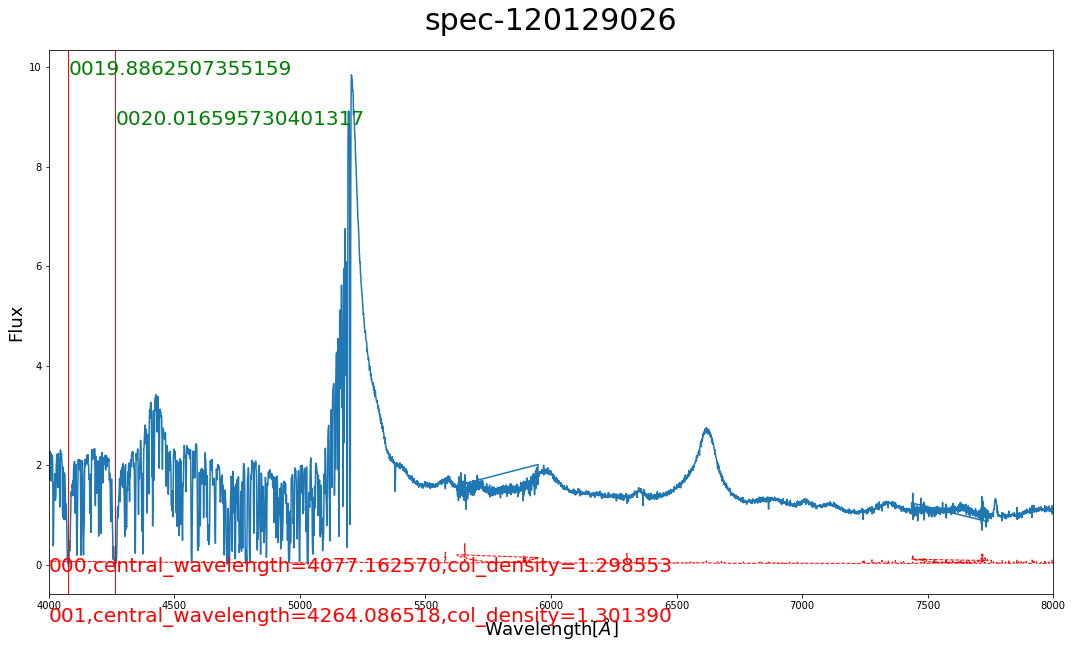

In [35]:
max_flux = max(sightline.flux)
plt.figure(figsize=(18,10))
plt.title('spec-%s'%(str(sightline.id)),fontdict=None,loc='center',pad='20',fontsize=30,color='black')
plt.xlabel('Wavelength'+'['+'$\AA$'+']',fontsize=18)
plt.ylabel('Flux',fontsize=18)
plt.xlim([4000,8000])
wavelength = np.exp(np.log(10)*sightline.loglam)
plt.plot(wavelength,sightline.flux)
plt.plot(wavelength,sightline.error,color='red',ls='--',linewidth=1)
for i in range(len(sightline.dlas)):
    plt.axvline(x=sightline.dlas[i].central_wavelength,ls="-",c="red",linewidth=1)
    plt.text(sightline.dlas[i].central_wavelength,max_flux-i,'00%s'%(np.exp(sightline.dlas[i].col_density*np.log(10))),fontsize=20,color='green')
    plt.text(4000,max_flux-10-i,'%s,central_wavelength=%f,col_density=%f'%(sightline.dlas[i].id,sightline.dlas[i].central_wavelength,sightline.dlas[i].col_density),fontsize=20,color='red')
plt.show()